In [1]:
# 04_ml_modeling.ipynb

# --- Imports ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

from pathlib import Path
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

# --- Load dataset ---
df = pd.read_csv("../../dataset/processed/merged_gold_macro_final_20250331_170349.csv", parse_dates=["Date"])
df.sort_values("Date", inplace=True)
df.reset_index(drop=True, inplace=True)

# --- Print structure ---
print("✅ Dataset loaded:")
print(df.info())
print(df.head())


✅ Dataset loaded:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2764 entries, 0 to 2763
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Date                2764 non-null   datetime64[ns]
 1   Open                2764 non-null   float64       
 2   High                2764 non-null   float64       
 3   Low                 2764 non-null   float64       
 4   Close               2764 non-null   float64       
 5   Adj_Close           2764 non-null   float64       
 6   Volume              2764 non-null   float64       
 7   USD_Index           2764 non-null   float64       
 8   CPI                 2764 non-null   float64       
 9   Yield_10Y           2764 non-null   float64       
 10  headline_count      2764 non-null   int64         
 11  avg_sentiment       2764 non-null   float64       
 12  std_sentiment       2764 non-null   float64       
 13  gold_return         2764 non-n

In [2]:
def save_model_results(model_name, parameters, exog_features, mae, rmse, r2, notes="", csv_path="../../results/model_metrics_log.csv"):
    result = pd.DataFrame([{
        "Model": model_name,
        "Parameters": parameters,
        "Exogenous_Features": exog_features,
        "MAE": mae,
        "RMSE": rmse,
        "R2_Score": r2,
        "Notes": notes
    }])

    # Create folder if it doesn't exist
    Path(csv_path).parent.mkdir(parents=True, exist_ok=True)

    # Append to CSV or create new
    try:
        existing = pd.read_csv(csv_path)
        updated = pd.concat([existing, result], ignore_index=True)
    except FileNotFoundError:
        updated = result

    updated.to_csv(csv_path, index=False)
    print(f"✅ Saved model result to: {csv_path}")

In [3]:
def save_forecast_results(dates, actual, forecast, model_name, csv_path="../../results/model_forecasts_log.csv"):
    forecast_df = pd.DataFrame({
        "Date": dates,
        "Actual": actual,
        "Forecast": forecast,
        "Model": model_name
    })

    Path(csv_path).parent.mkdir(parents=True, exist_ok=True)

    try:
        existing = pd.read_csv(csv_path)
        updated = pd.concat([existing, forecast_df], ignore_index=True)
    except FileNotFoundError:
        updated = forecast_df

    updated.to_csv(csv_path, index=False)
    print(f"📈 Saved forecast data for {model_name} to: {csv_path}")


In [4]:
# --- Train-Test Split for Machine Learning ---

# Target variable
target_col = "Adj_Close"

# Predictors (exclude future-leaking variables like raw Adj_Close or rolling means with future look-ahead)
feature_cols = [
    # Lag features
    "gold_lag_1", "gold_lag_7", "gold_lag_30",
    "usd_index_lag_1", "usd_index_lag_7", "usd_index_lag_30",
    "sentiment_lag_1", "sentiment_lag_7", "sentiment_lag_30",
    
    # Others
    "USD_Index", "CPI", "Yield_10Y", "headline_count", "avg_sentiment",
    "gold_return"
]

# Drop rows with missing values in predictors
ml_df = df.dropna(subset=feature_cols + [target_col]).copy()

# Split into Train (2012–2023) and Test (2024)
train_df_ml = ml_df[ml_df["Date"] < "2024-01-01"].copy()
test_df_ml = ml_df[ml_df["Date"] >= "2024-01-01"].copy()

# Split into X (features) and y (target)
X_train = train_df_ml[feature_cols]
y_train = train_df_ml[target_col]

X_test = test_df_ml[feature_cols]
y_test = test_df_ml[target_col]

print("✅ ML Train-Test Split Completed")
print("X_train:", X_train.shape)
print("X_test :", X_test.shape)


✅ ML Train-Test Split Completed
X_train: (2513, 15)
X_test : (251, 15)



=== Random Forest (Univariate) Evaluation on 2024 ===
MAE: 352.31
RMSE: 413.06
R² Score: -2.4206


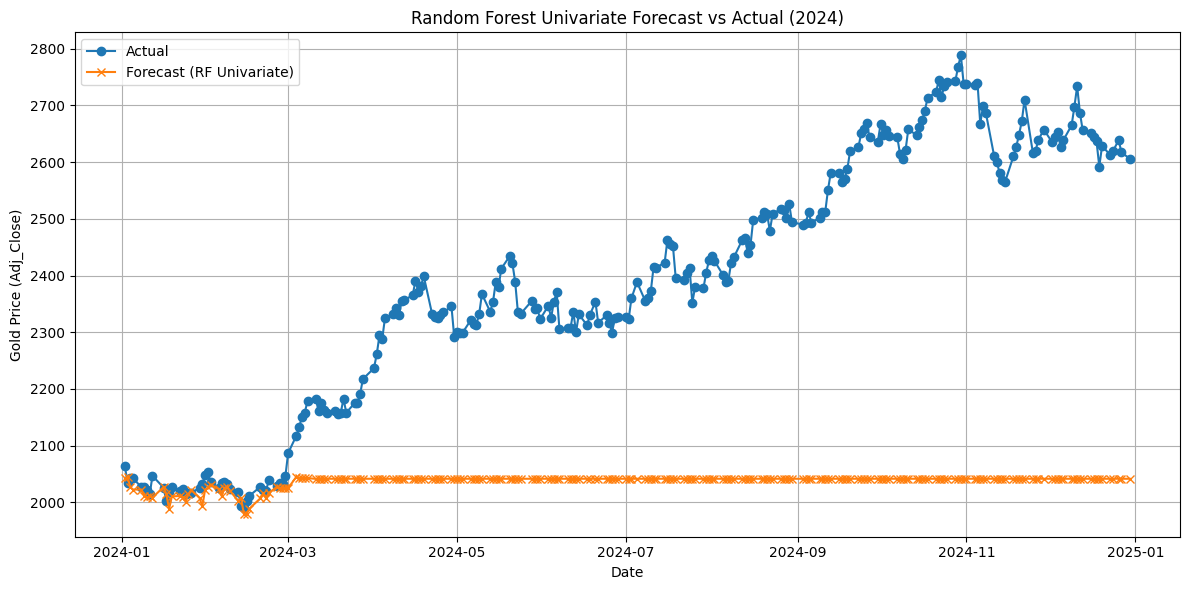

✅ Saved model result to: ../../results/model_metrics_log.csv
📈 Saved forecast data for Random Forest (Univariate) to: ../../results/model_forecasts_log.csv


In [5]:
# --- Random Forest (Univariate) Model Training and Forecasting ---

# Define lag-only features for univariate modeling
univariate_features = ["gold_lag_1", "gold_lag_7", "gold_lag_30"]

# Extract train/test data for univariate Random Forest
X_train_uni = train_df_ml[univariate_features]
X_test_uni = test_df_ml[univariate_features]

# Initialize and train the model
rf_uni = RandomForestRegressor(n_estimators=100, random_state=42)
rf_uni.fit(X_train_uni, y_train)

# Forecast for 2024
y_pred_rf_uni = rf_uni.predict(X_test_uni)

# --- Evaluation ---
mae_rf_uni = mean_absolute_error(y_test, y_pred_rf_uni)
rmse_rf_uni = np.sqrt(mean_squared_error(y_test, y_pred_rf_uni))
r2_rf_uni = r2_score(y_test, y_pred_rf_uni)

print("\n=== Random Forest (Univariate) Evaluation on 2024 ===")
print(f"MAE: {mae_rf_uni:.2f}")
print(f"RMSE: {rmse_rf_uni:.2f}")
print(f"R² Score: {r2_rf_uni:.4f}")

# --- Plot Forecast vs Actual ---
plt.figure(figsize=(12, 6))
plt.plot(test_df_ml["Date"], y_test, label="Actual", marker="o")
plt.plot(test_df_ml["Date"], y_pred_rf_uni, label="Forecast (RF Univariate)", marker="x")
plt.title("Random Forest Univariate Forecast vs Actual (2024)")
plt.xlabel("Date")
plt.ylabel("Gold Price (Adj_Close)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Save Results ---
save_model_results(
    model_name="Random Forest",
    parameters="n_estimators=100",
    exog_features=", ".join(univariate_features),
    mae=mae_rf_uni,
    rmse=rmse_rf_uni,
    r2=r2_rf_uni,
    notes="Univariate (lags only)"
)

save_forecast_results(
    dates=test_df_ml["Date"],
    actual=y_test,
    forecast=y_pred_rf_uni,
    model_name="Random Forest (Univariate)"
)



=== Random Forest (Multivariate) Evaluation on 2024 ===
MAE: 343.23
RMSE: 405.60
R² Score: -2.2981


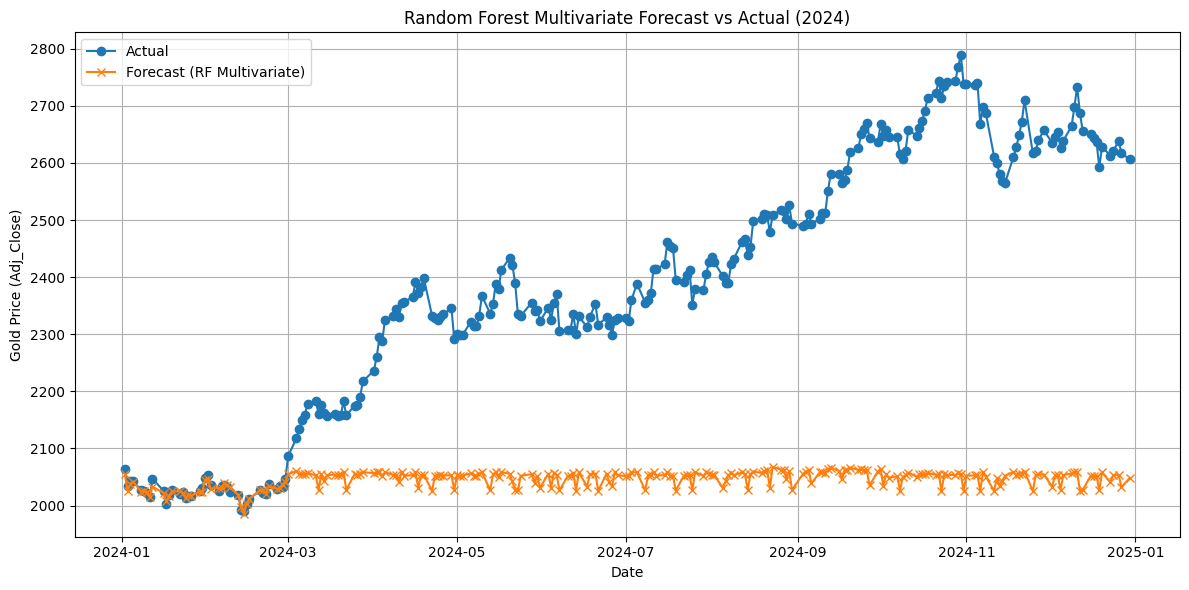

✅ Saved model result to: ../../results/model_metrics_log.csv
📈 Saved forecast data for Random Forest (Multivariate) to: ../../results/model_forecasts_log.csv


In [6]:
# --- Random Forest (Multivariate) Model Training and Forecasting ---

# Use full feature set for multivariate modeling
X_train_multi = train_df_ml[feature_cols]
X_test_multi = test_df_ml[feature_cols]

# Initialize and train the model
rf_multi = RandomForestRegressor(n_estimators=100, random_state=42)
rf_multi.fit(X_train_multi, y_train)

# Forecast for 2024
y_pred_rf_multi = rf_multi.predict(X_test_multi)

# --- Evaluation ---
mae_rf_multi = mean_absolute_error(y_test, y_pred_rf_multi)
rmse_rf_multi = np.sqrt(mean_squared_error(y_test, y_pred_rf_multi))
r2_rf_multi = r2_score(y_test, y_pred_rf_multi)

print("\n=== Random Forest (Multivariate) Evaluation on 2024 ===")
print(f"MAE: {mae_rf_multi:.2f}")
print(f"RMSE: {rmse_rf_multi:.2f}")
print(f"R² Score: {r2_rf_multi:.4f}")

# --- Plot Forecast vs Actual ---
plt.figure(figsize=(12, 6))
plt.plot(test_df_ml["Date"], y_test, label="Actual", marker="o")
plt.plot(test_df_ml["Date"], y_pred_rf_multi, label="Forecast (RF Multivariate)", marker="x")
plt.title("Random Forest Multivariate Forecast vs Actual (2024)")
plt.xlabel("Date")
plt.ylabel("Gold Price (Adj_Close)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Save Results ---
save_model_results(
    model_name="Random Forest",
    parameters="n_estimators=100",
    exog_features=", ".join(feature_cols),
    mae=mae_rf_multi,
    rmse=rmse_rf_multi,
    r2=r2_rf_multi,
    notes="Multivariate"
)

save_forecast_results(
    dates=test_df_ml["Date"],
    actual=y_test,
    forecast=y_pred_rf_multi,
    model_name="Random Forest (Multivariate)"
)



=== XGBoost (Univariate) Evaluation on 2024 ===
MAE: 355.86
RMSE: 417.36
R² Score: -2.4921


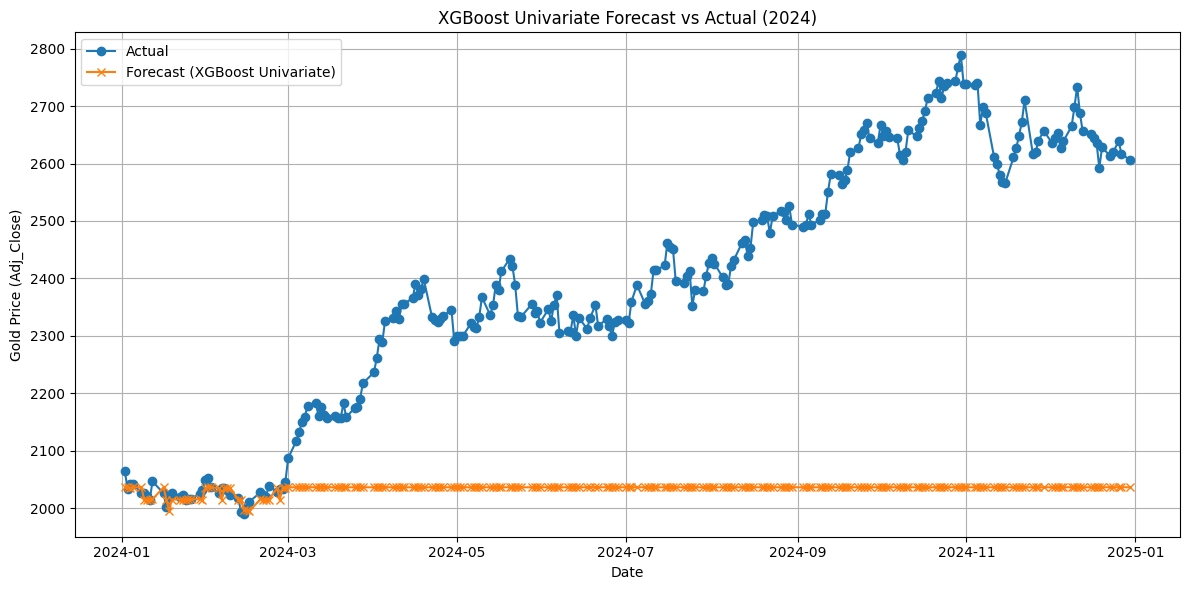

✅ Saved model result to: ../../results/model_metrics_log.csv
📈 Saved forecast data for XGBoost (Univariate) to: ../../results/model_forecasts_log.csv


In [7]:
# --- XGBoost (Univariate) Model Training and Forecasting ---

# Use only gold_lag_1 as the univariate feature
X_train_uni = train_df_ml[["gold_lag_1"]]
X_test_uni = test_df_ml[["gold_lag_1"]]

# Initialize and train the model
xgb_uni = XGBRegressor(n_estimators=100, random_state=42)
xgb_uni.fit(X_train_uni, y_train)

# Forecast for 2024
y_pred_xgb_uni = xgb_uni.predict(X_test_uni)

# --- Evaluation ---
mae_xgb_uni = mean_absolute_error(y_test, y_pred_xgb_uni)
rmse_xgb_uni = np.sqrt(mean_squared_error(y_test, y_pred_xgb_uni))
r2_xgb_uni = r2_score(y_test, y_pred_xgb_uni)

print("\n=== XGBoost (Univariate) Evaluation on 2024 ===")
print(f"MAE: {mae_xgb_uni:.2f}")
print(f"RMSE: {rmse_xgb_uni:.2f}")
print(f"R² Score: {r2_xgb_uni:.4f}")

# --- Plot Forecast vs Actual ---
plt.figure(figsize=(12, 6))
plt.plot(test_df_ml["Date"], y_test, label="Actual", marker="o")
plt.plot(test_df_ml["Date"], y_pred_xgb_uni, label="Forecast (XGBoost Univariate)", marker="x")
plt.title("XGBoost Univariate Forecast vs Actual (2024)")
plt.xlabel("Date")
plt.ylabel("Gold Price (Adj_Close)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Save Results ---
save_model_results(
    model_name="XGBoost",
    parameters="n_estimators=100",
    exog_features="gold_lag_1",
    mae=mae_xgb_uni,
    rmse=rmse_xgb_uni,
    r2=r2_xgb_uni,
    notes="Univariate using gold_lag_1"
)

save_forecast_results(
    dates=test_df_ml["Date"],
    actual=y_test,
    forecast=y_pred_xgb_uni,
    model_name="XGBoost (Univariate)"
)



=== XGBoost Univariate (gold_lag_7) ===
MAE: 399.06, RMSE: 458.38, R²: -3.2124


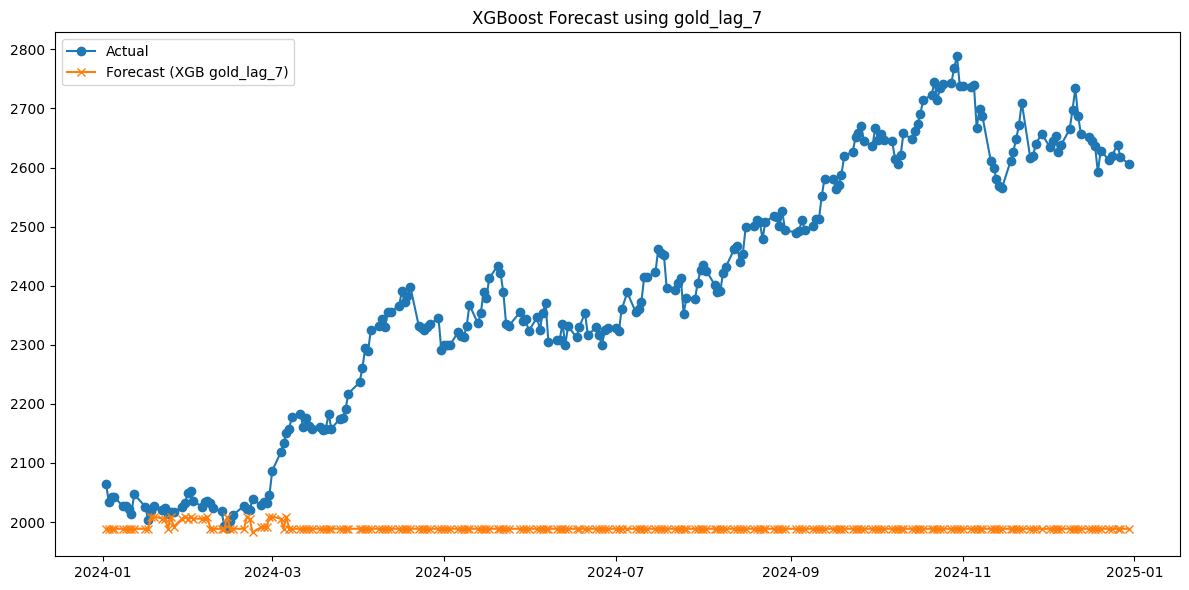

✅ Saved model result to: ../../results/model_metrics_log.csv
📈 Saved forecast data for XGBoost (Univariate gold_lag_7) to: ../../results/model_forecasts_log.csv


In [8]:
# --- XGBoost Univariate (gold_lag_7) ---

X_train_uni7 = train_df_ml[["gold_lag_7"]]
X_test_uni7 = test_df_ml[["gold_lag_7"]]

xgb_uni7 = XGBRegressor(n_estimators=100, random_state=42)
xgb_uni7.fit(X_train_uni7, y_train)
y_pred_uni7 = xgb_uni7.predict(X_test_uni7)

mae = mean_absolute_error(y_test, y_pred_uni7)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_uni7))
r2 = r2_score(y_test, y_pred_uni7)

print("\n=== XGBoost Univariate (gold_lag_7) ===")
print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.4f}")

# Plot
plt.figure(figsize=(12, 6))
plt.plot(test_df_ml["Date"], y_test, label="Actual", marker="o")
plt.plot(test_df_ml["Date"], y_pred_uni7, label="Forecast (XGB gold_lag_7)", marker="x")
plt.title("XGBoost Forecast using gold_lag_7")
plt.legend()
plt.tight_layout()
plt.show()

# Save
save_model_results("XGBoost", "n_estimators=100", "gold_lag_7", mae, rmse, r2, "Univariate with gold_lag_7")
save_forecast_results(test_df_ml["Date"], y_test, y_pred_uni7, "XGBoost (Univariate gold_lag_7)")



=== XGBoost Univariate (gold_lag_30) Evaluation ===
MAE: 440.06
RMSE: 492.76
R² Score: -3.8680


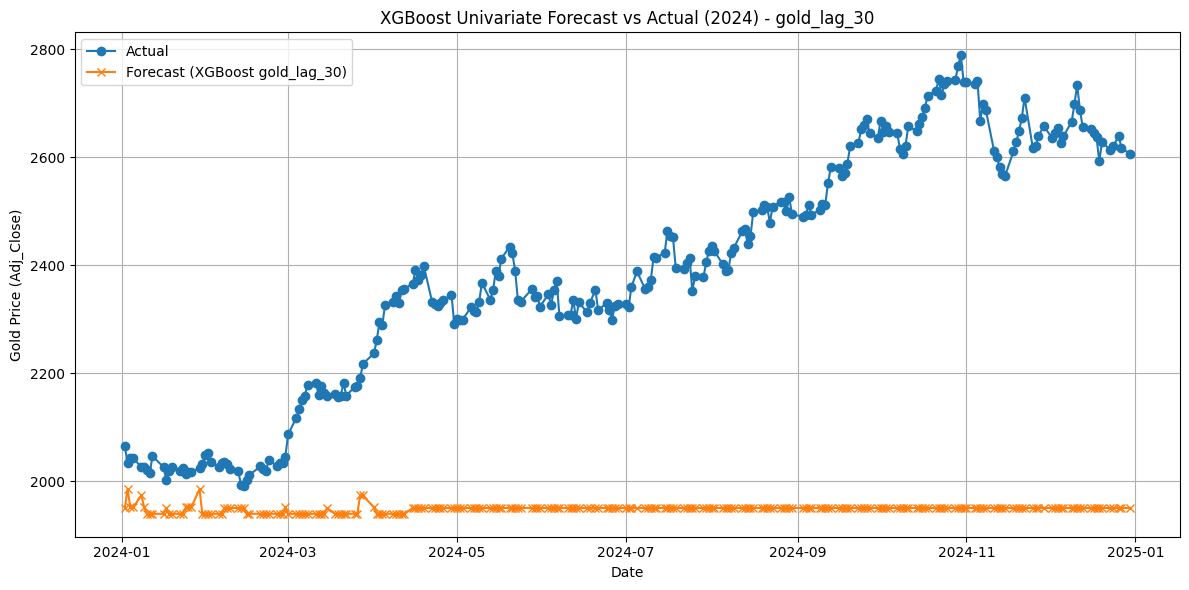

✅ Saved model result to: ../../results/model_metrics_log.csv
📈 Saved forecast data for XGBoost (Univariate gold_lag_30) to: ../../results/model_forecasts_log.csv


In [9]:
# --- XGBoost Univariate (gold_lag_30) ---

# Prepare data
X_train_uni30 = train_df_ml[["gold_lag_30"]]
X_test_uni30 = test_df_ml[["gold_lag_30"]]

# Initialize and fit model
xgb_uni30 = XGBRegressor(n_estimators=100, random_state=42)
xgb_uni30.fit(X_train_uni30, y_train)

# Forecast
y_pred_uni30 = xgb_uni30.predict(X_test_uni30)

# Evaluation
mae_uni30 = mean_absolute_error(y_test, y_pred_uni30)
rmse_uni30 = np.sqrt(mean_squared_error(y_test, y_pred_uni30))
r2_uni30 = r2_score(y_test, y_pred_uni30)

print("\n=== XGBoost Univariate (gold_lag_30) Evaluation ===")
print(f"MAE: {mae_uni30:.2f}")
print(f"RMSE: {rmse_uni30:.2f}")
print(f"R² Score: {r2_uni30:.4f}")

# Plot forecast vs actual
plt.figure(figsize=(12, 6))
plt.plot(test_df_ml["Date"], y_test, label="Actual", marker="o")
plt.plot(test_df_ml["Date"], y_pred_uni30, label="Forecast (XGBoost gold_lag_30)", marker="x")
plt.title("XGBoost Univariate Forecast vs Actual (2024) - gold_lag_30")
plt.xlabel("Date")
plt.ylabel("Gold Price (Adj_Close)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Save results
save_model_results(
    model_name="XGBoost",
    parameters="n_estimators=100",
    exog_features="gold_lag_30",
    mae=mae_uni30,
    rmse=rmse_uni30,
    r2=r2_uni30,
    notes="Univariate with gold_lag_30"
)

save_forecast_results(
    dates=test_df_ml["Date"],
    actual=y_test,
    forecast=y_pred_uni30,
    model_name="XGBoost (Univariate gold_lag_30)"
)



=== XGBoost (All Lag Features) Evaluation ===
MAE: 370.22
RMSE: 430.18
R² Score: -2.7099


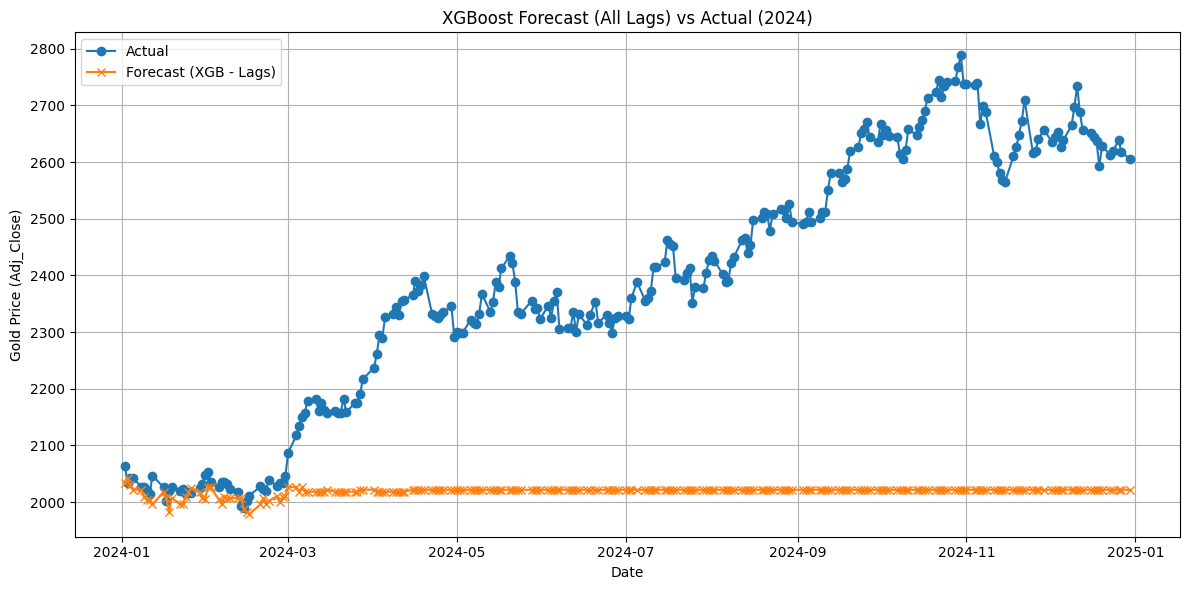

✅ Saved model result to: ../../results/model_metrics_log.csv
📈 Saved forecast data for XGBoost (Univariate - all lags) to: ../../results/model_forecasts_log.csv


In [10]:
# --- XGBoost with all 3 lag features as univariate input ---

# Feature set: only lagged Adj_Close
lag_features = ["gold_lag_1", "gold_lag_7", "gold_lag_30"]

# Train the model
xgb_lags_model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1
)
xgb_lags_model.fit(X_train[lag_features], y_train)

# Forecast
xgb_lags_pred = xgb_lags_model.predict(X_test[lag_features])

# Evaluation
mae_xgb_lags = mean_absolute_error(y_test, xgb_lags_pred)
rmse_xgb_lags = np.sqrt(mean_squared_error(y_test, xgb_lags_pred))
r2_xgb_lags = r2_score(y_test, xgb_lags_pred)

print("\n=== XGBoost (All Lag Features) Evaluation ===")
print(f"MAE: {mae_xgb_lags:.2f}")
print(f"RMSE: {rmse_xgb_lags:.2f}")
print(f"R² Score: {r2_xgb_lags:.4f}")

# Plot Forecast vs Actual
plt.figure(figsize=(12, 6))
plt.plot(test_df_ml["Date"], y_test.values, label="Actual", marker="o")
plt.plot(test_df_ml["Date"], xgb_lags_pred, label="Forecast (XGB - Lags)", marker="x")
plt.title("XGBoost Forecast (All Lags) vs Actual (2024)")
plt.xlabel("Date")
plt.ylabel("Gold Price (Adj_Close)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Save results
save_model_results(
    model_name="XGBoost",
    parameters="n_estimators=100, learning_rate=0.1",
    exog_features=", ".join(lag_features),
    mae=mae_xgb_lags,
    rmse=rmse_xgb_lags,
    r2=r2_xgb_lags,
    notes="Univariate using all lag features"
)

save_forecast_results(
    dates=test_df_ml["Date"],
    actual=y_test.values,
    forecast=xgb_lags_pred,
    model_name="XGBoost (Univariate - all lags)"
)


=== XGBoost (Multivariate) Evaluation ===
MAE: 356.87
RMSE: 419.14
R² Score: -2.5220


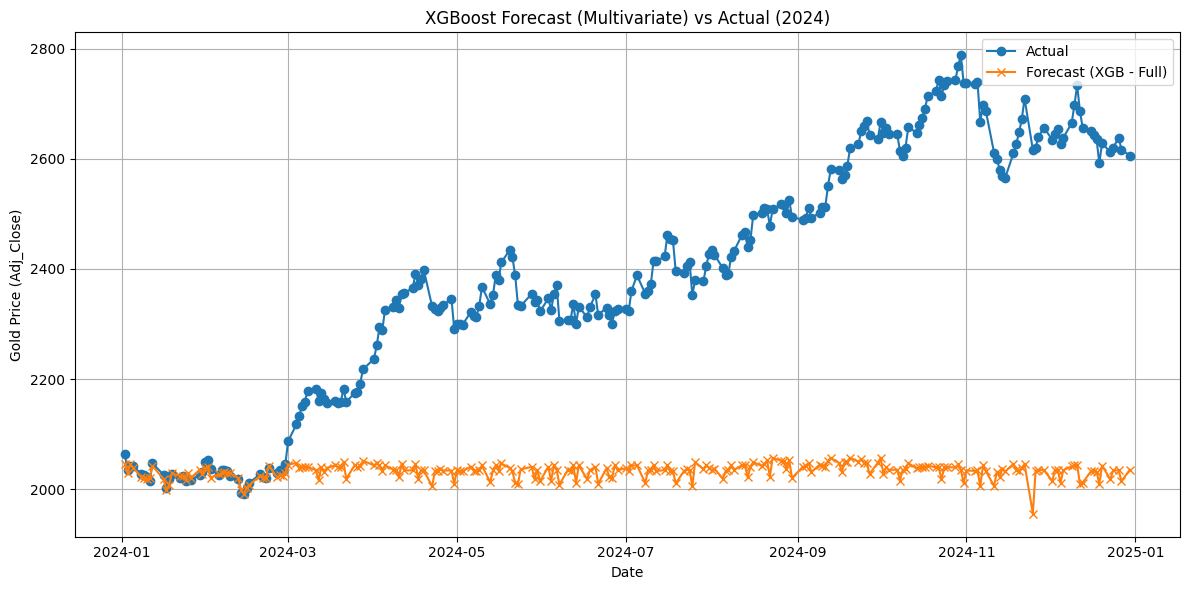

✅ Saved model result to: ../../results/model_metrics_log.csv
📈 Saved forecast data for XGBoost (Multivariate) to: ../../results/model_forecasts_log.csv


In [11]:
# --- XGBoost with all predictors (multivariate) ---

# Train the model
xgb_full_model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1
)
xgb_full_model.fit(X_train, y_train)

# Forecast
xgb_full_pred = xgb_full_model.predict(X_test)

# Evaluation
mae_xgb_full = mean_absolute_error(y_test, xgb_full_pred)
rmse_xgb_full = np.sqrt(mean_squared_error(y_test, xgb_full_pred))
r2_xgb_full = r2_score(y_test, xgb_full_pred)

print("\n=== XGBoost (Multivariate) Evaluation ===")
print(f"MAE: {mae_xgb_full:.2f}")
print(f"RMSE: {rmse_xgb_full:.2f}")
print(f"R² Score: {r2_xgb_full:.4f}")

# --- Plot Forecast vs Actual ---
plt.figure(figsize=(12, 6))
plt.plot(test_df_ml["Date"], y_test.values, label="Actual", marker="o")
plt.plot(test_df_ml["Date"], xgb_full_pred, label="Forecast (XGB - Full)", marker="x")
plt.title("XGBoost Forecast (Multivariate) vs Actual (2024)")
plt.xlabel("Date")
plt.ylabel("Gold Price (Adj_Close)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Save model results
save_model_results(
    model_name="XGBoost",
    parameters="n_estimators=100, learning_rate=0.1",
    exog_features=", ".join(feature_cols),
    mae=mae_xgb_full,
    rmse=rmse_xgb_full,
    r2=r2_xgb_full,
    notes="Multivariate XGBoost using all predictors"
)

# Save forecast results
save_forecast_results(
    dates=test_df_ml["Date"],
    actual=y_test.values,
    forecast=xgb_full_pred,
    model_name="XGBoost (Multivariate)"
)


In [12]:
from sklearn.model_selection import ParameterGrid

# Define the hyperparameter grid
param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5],
    "max_features": ["sqrt", "log2", None]
}

grid = list(ParameterGrid(param_grid))

best_model = None
best_metrics = {"mae": float("inf")}

print(f"🔍 Tuning {len(grid)} combinations...")

for params in grid:
    model = RandomForestRegressor(
        n_estimators=params["n_estimators"],
        max_depth=params["max_depth"],
        min_samples_split=params["min_samples_split"],
        max_features=params["max_features"],
        random_state=42,
        n_jobs=-1
    )
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    print(f"{params} → MAE: {mae:.2f} | RMSE: {rmse:.2f} | R²: {r2:.4f}")
    
    # Save best
    if mae < best_metrics["mae"]:
        best_model = model
        best_metrics.update({
            "mae": mae,
            "rmse": rmse,
            "r2": r2,
            "params": params,
            "y_pred": y_pred
        })

# --- Save the best tuned model result ---
save_model_results(
    model_name="Random Forest (Tuned)",
    parameters=str(best_metrics["params"]),
    exog_features=", ".join(feature_cols),
    mae=best_metrics["mae"],
    rmse=best_metrics["rmse"],
    r2=best_metrics["r2"],
    notes="Tuned multivariate Random Forest"
)

# --- Save the forecast ---
save_forecast_results(
    dates=test_df_ml["Date"],
    actual=y_test.values,
    forecast=best_metrics["y_pred"],
    model_name="Random Forest (Tuned)"
)


🔍 Tuning 36 combinations...
{'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 100} → MAE: 392.61 | RMSE: 454.29 | R²: -3.1375
{'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 200} → MAE: 391.40 | RMSE: 452.80 | R²: -3.1104
{'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 100} → MAE: 388.63 | RMSE: 451.16 | R²: -3.0806
{'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 200} → MAE: 387.89 | RMSE: 449.69 | R²: -3.0541
{'max_depth': None, 'max_features': 'log2', 'min_samples_split': 2, 'n_estimators': 100} → MAE: 392.61 | RMSE: 454.29 | R²: -3.1375
{'max_depth': None, 'max_features': 'log2', 'min_samples_split': 2, 'n_estimators': 200} → MAE: 391.40 | RMSE: 452.80 | R²: -3.1104
{'max_depth': None, 'max_features': 'log2', 'min_samples_split': 5, 'n_estimators': 100} → MAE: 388.63 | RMSE: 451.16 | R²: -3.0806
{'max_depth': None, 'max_features': 'log2', 'min

Params: {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 3} | MAE: 343.69 | RMSE: 406.35 | R²: -2.3103
Params: {'n_estimators': 200, 'learning_rate': 0.1, 'max_depth': 3} | MAE: 343.11 | RMSE: 405.73 | R²: -2.3003
Params: {'n_estimators': 100, 'learning_rate': 0.05, 'max_depth': 4} | MAE: 356.01 | RMSE: 418.18 | R²: -2.5059
Params: {'n_estimators': 200, 'learning_rate': 0.05, 'max_depth': 4} | MAE: 344.54 | RMSE: 407.18 | R²: -2.3240
Params: {'n_estimators': 100, 'learning_rate': 0.01, 'max_depth': 5} | MAE: 576.69 | RMSE: 618.41 | R²: -6.6671

✅ Best XGBoost Parameters: {'n_estimators': 200, 'learning_rate': 0.1, 'max_depth': 3}


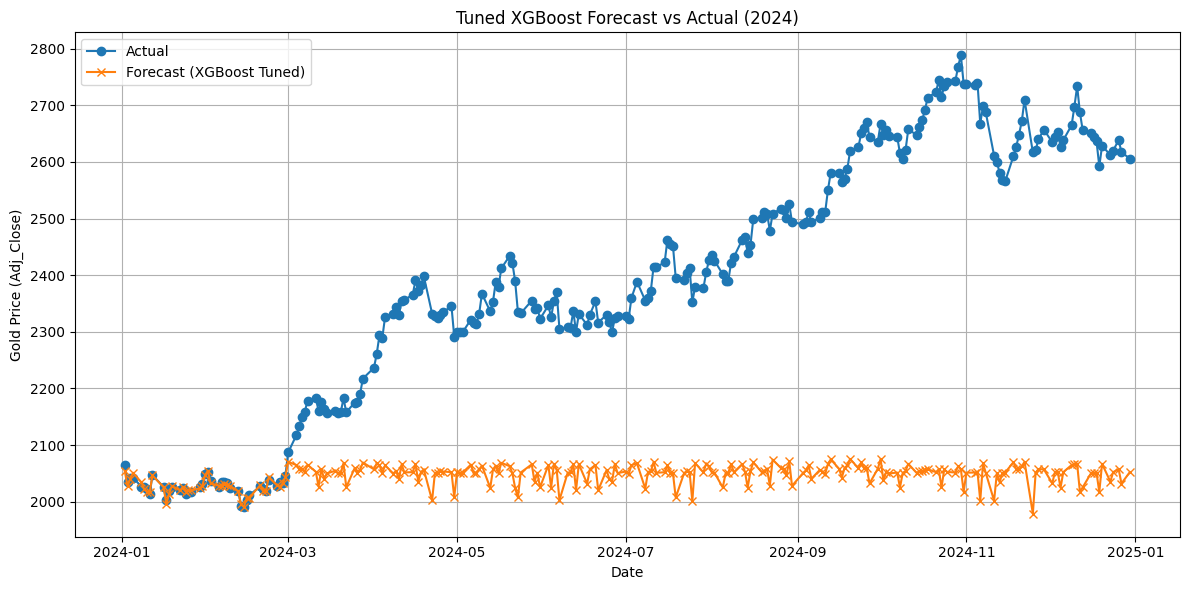

✅ Saved model result to: ../../results/model_metrics_log.csv
📈 Saved forecast data for XGBoost (Tuned) to: ../../results/model_forecasts_log.csv


In [13]:
# --- Tuned XGBoost (Multivariate) Model Training and Forecasting ---

from xgboost import XGBRegressor

# Features
xgb_features = [
    "gold_lag_1", "gold_lag_7", "gold_lag_30",
    "usd_index_lag_1", "usd_index_lag_7", "usd_index_lag_30",
    "sentiment_lag_1", "sentiment_lag_7", "sentiment_lag_30",
    "USD_Index", "CPI", "Yield_10Y", 
    "headline_count", "avg_sentiment", "gold_return"
]

X_train = train_df_ml[xgb_features]
y_train = train_df_ml["Adj_Close"]

X_test = test_df_ml[xgb_features]
y_test = test_df_ml["Adj_Close"]

# Parameter Grid
param_grid = [
    {"n_estimators": 100, "learning_rate": 0.1, "max_depth": 3},
    {"n_estimators": 200, "learning_rate": 0.1, "max_depth": 3},
    {"n_estimators": 100, "learning_rate": 0.05, "max_depth": 4},
    {"n_estimators": 200, "learning_rate": 0.05, "max_depth": 4},
    {"n_estimators": 100, "learning_rate": 0.01, "max_depth": 5},
]

best_mae = float("inf")
best_model = None
best_params = None

for params in param_grid:
    model = XGBRegressor(
        n_estimators=params["n_estimators"],
        learning_rate=params["learning_rate"],
        max_depth=params["max_depth"],
        objective="reg:squarederror",
        n_jobs=-1,
        random_state=42
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    print(f"Params: {params} | MAE: {mae:.2f} | RMSE: {rmse:.2f} | R²: {r2:.4f}")

    if mae < best_mae:
        best_mae = mae
        best_model = model
        best_params = params
        best_preds = y_pred

# --- Evaluation and Logging ---
print("\n✅ Best XGBoost Parameters:", best_params)

mae = mean_absolute_error(y_test, best_preds)
rmse = np.sqrt(mean_squared_error(y_test, best_preds))
r2 = r2_score(y_test, best_preds)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(test_df_ml["Date"], y_test.values, label="Actual", marker="o")
plt.plot(test_df_ml["Date"], best_preds, label="Forecast (XGBoost Tuned)", marker="x")
plt.title("Tuned XGBoost Forecast vs Actual (2024)")
plt.xlabel("Date")
plt.ylabel("Gold Price (Adj_Close)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Save Results
save_model_results(
    model_name="XGBoost (Tuned)",
    parameters=str(best_params),
    exog_features=", ".join(xgb_features),
    mae=mae,
    rmse=rmse,
    r2=r2,
    notes="Tuned multivariate XGBoost"
)

save_forecast_results(
    dates=test_df_ml["Date"],
    actual=y_test.values,
    forecast=best_preds,
    model_name="XGBoost (Tuned)"
)


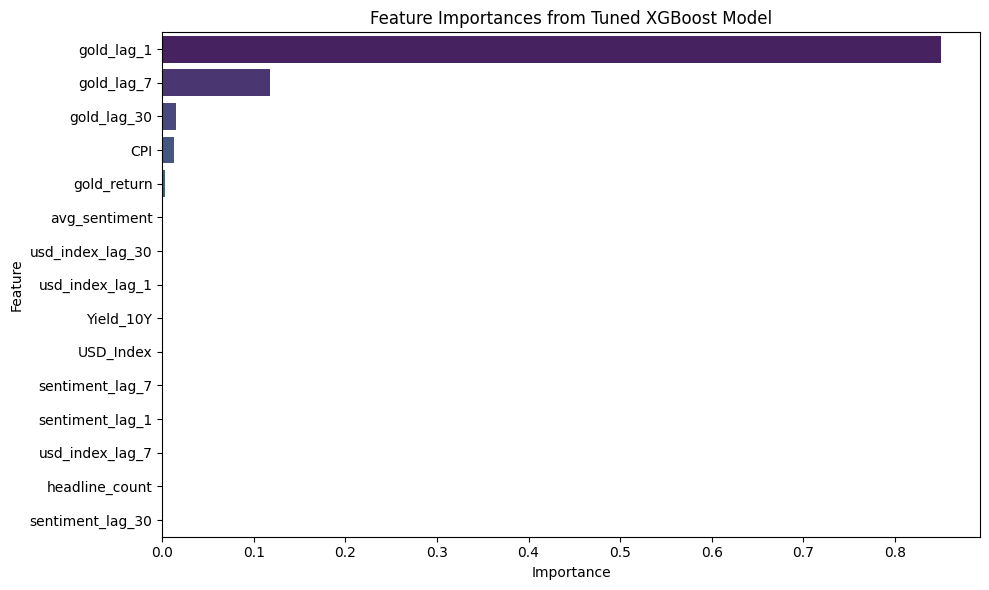

In [14]:
# --- XGBoost Feature Importance Analysis ---

# Get feature importances from tuned XGBoost
importances = best_model.feature_importances_
feat_imp_df = pd.DataFrame({
    "Feature": xgb_features,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=feat_imp_df, x="Importance", y="Feature", palette="viridis")
plt.title("Feature Importances from Tuned XGBoost Model")
plt.tight_layout()
plt.show()
